# Implémentez un modèle de scoring

In [2]:
# librairies de base
import pandas as pd
import numpy as np
import warnings
import os
import sys
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
import pickle
import gc
import time
from contextlib import contextmanager
from urllib.parse import urlparse
import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [3]:
# librairies de dataviz
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [4]:
# Sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from imblearn.datasets import make_imbalance
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE


import mlflow
import mlflow.sklearn
import mlflow.pyfunc

In [5]:
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
import shap

In [7]:
import joblib
from mlflow.models.signature import infer_signature

# Données brutes

- **application_{train|test}.csv**

Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

- **bureau.csv**

Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

- **bureau_balance.csv**

Soldes mensuels des crédits antérieurs au bureau de crédit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes.

- **POS_CASH_balance.csv**

Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

- **credit_card_balance.csv**

Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

- **previous_application.csv**

Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

- **installments_payments.csv**

Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

- **HomeCredit_columns_description.csv**

Ce fichier contient les descriptions des colonnes des différents fichiers de données.

In [8]:
# Chargement des données
path = '/Users/alexandredelaguillaumie/Documents/Projet 7/Datasets'
df_application_train = pd.read_csv(os.path.join(path,
                                                "application_train.csv"))
df_application_test = pd.read_csv(os.path.join(path,
                                               "application_test.csv"))
df_bureau = pd.read_csv(os.path.join(path,
                                     "bureau.csv"))
df_bureau_balance = pd.read_csv(os.path.join(path,
                                             "bureau_balance.csv"))
df_credit_card_balance = pd.read_csv(os.path.join(path,
                                                  "credit_card_balance.csv"))
df_installments_payments = pd.read_csv(os.path.join(path,
                                                    "installments_payments.csv"))
df_previous_application = pd.read_csv(os.path.join(path,
                                                   "previous_application.csv"))
df_POS_CASH_balance = pd.read_csv(os.path.join(path,
                                               "POS_CASH_balance.csv"))

In [9]:
print("Dimensions")

dict_df = {'application_train shape :': df_application_train.shape, 
           'application_test shape :' : df_application_test.shape, 
           'bureau shape :' : df_bureau.shape,
           'bureau_balance shape :' : df_bureau_balance.shape,
           'POS_CASH_balance shape :' : df_POS_CASH_balance.shape, 
           'credit_card_balance shape :' : df_credit_card_balance.shape, 
           'installments_payments shape :' : df_installments_payments.shape, 
           'previous_application shape:' : df_previous_application.shape}

for key, value in dict_df.items():
    print(f'{key :-<30} {value}')

Dimensions
application_train shape :----- (307511, 122)
application_test shape :------ (48744, 121)
bureau shape :---------------- (1716428, 17)
bureau_balance shape :-------- (27299925, 3)
POS_CASH_balance shape :------ (10001358, 8)
credit_card_balance shape :--- (3840312, 23)
installments_payments shape :- (13605401, 8)
previous_application shape:--- (1670214, 37)


In [10]:
print("Number of inf")

dict_df = {'application_train shape :': (df_application_train == 'inf').sum().sum(),
           'application_test shape :' : (df_application_test == 'inf').sum().sum(), 
           'bureau shape :' : (df_bureau == 'inf').sum().sum(),
           'bureau_balance shape :' : (df_bureau_balance == 'inf').sum().sum(),
           'POS_CASH_balance shape :' : (df_POS_CASH_balance == 'inf').sum().sum(), 
           'credit_card_balance shape :' : (df_credit_card_balance == 'inf').sum().sum(), 
           'installments_payments shape :' : (df_installments_payments == 'inf').sum().sum(), 
           'previous_application shape:' : (df_previous_application == 'inf').sum().sum()}

for key, value in dict_df.items():
    print(f'{key :-<30} {value}')

Number of inf
application_train shape :----- 0
application_test shape :------ 0
bureau shape :---------------- 0
bureau_balance shape :-------- 0
POS_CASH_balance shape :------ 0
credit_card_balance shape :--- 0
installments_payments shape :- 0
previous_application shape:--- 0


In [11]:
print("Number of NaN")

dict_df = {'application_train shape :': df_application_train.isna().sum().sum(),
           'application_test shape :' : df_application_test.isna().sum().sum(), 
           'bureau shape :' : df_bureau.isna().sum().sum(),
           'bureau_balance shape :' : df_bureau_balance.isna().sum().sum(),
           'POS_CASH_balance shape :' : df_POS_CASH_balance.isna().sum().sum(), 
           'credit_card_balance shape :' : df_credit_card_balance.isna().sum().sum(), 
           'installments_payments shape :' : df_installments_payments.isna().sum().sum(), 
           'previous_application shape:' : df_previous_application.isna().sum().sum()}

for key, value in dict_df.items():
    print(f'{key :-<30} {value}')

Number of NaN
application_train shape :----- 9152465
application_test shape :------ 1404419
bureau shape :---------------- 3939947
bureau_balance shape :-------- 0
POS_CASH_balance shape :------ 52158
credit_card_balance shape :--- 5877356
installments_payments shape :- 5810
previous_application shape:--- 11109336


In [12]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title,
                                        time.time() 
                                        - t0))

# Fonctions

In [13]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df,
                    nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df,
                        columns= categorical_columns,
                        dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [14]:
def column_names(data):
    categorical_list = []
    numerical_list = []
    for i in data.columns.tolist():
        if data[i].dtype=='object':
            categorical_list.append(i)
        else:
            numerical_list.append(i)

    # Récupérer le nom des catégories
    cat = preprocessor.transformers_[1][1]\
          .get_feature_names(categorical_list)

    # Nom de l'ensemble des colonnes preprocessed
    column_names = numerical_list+cat.tolist()
    return column_names

In [15]:
def numerical_list(df):
    categorical_list = []
    numerical_list = []
    for i in df.columns.tolist():
        if df[i].dtype=='object':
            categorical_list.append(i)
        else:
            numerical_list.append(i)
    return numerical_list

In [16]:
def categorical_list(df):
    categorical_list = []
    numerical_list = []
    for i in df.columns.tolist():
        if df[i].dtype=='object':
            categorical_list.append(i)
        else:
            numerical_list.append(i)
    return categorical_list

In [17]:
def eva_func(y_true,
             y_pred,
             fn_value=-10,
             fp_value=0,
             tp_value=0,
             tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

In [18]:
def plot_heatmap_confusion(y_test,y_pred):
    
    plt.figure(1, figsize=(12, 4))
    results = {}

    conf_mx = confusion_matrix(y_test, y_pred)
    results = conf_mx
    mat_conf_df = pd.DataFrame(conf_mx,
                               columns=["Solvable", "Non Solvable"],
                               index=["Solvable", "Non Solvable"])

    sns.heatmap(mat_conf_df, annot=True, linewidths=.7, fmt='g',cmap='YlOrBr')

    plt.title('Matrice de confusion')
    plt.ylim(0, 2)
    plt.xlabel("Classes prédites")
    plt.ylabel("Classes réelles")
    plt.show()

In [19]:
def eval_metrics(actual,pred):
    balance_accuracy = balanced_accuracy_score(actual,pred)
    f1 = f1_score(actual,pred)
    roc_auc = roc_auc_score(actual,pred)
    accuracy_score = metrics.accuracy_score(actual,pred)
    fbeta_score = metrics.fbeta_score(actual,pred, beta=3)
    dictionnary = {}
    dictionnary['balance_accuracy'] = balance_accuracy
    dictionnary['f1'] = f1
    dictionnary['roc_auc'] = roc_auc
    dictionnary['accuracy_score'] = accuracy_score
    dictionnary['fbeta_score'] = fbeta_score
    return dictionnary

In [20]:
# Preprocess application_train.csv and application_test.csv
def application(num_rows = None,
                nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(os.path.join(path,
                                  'application_train.csv'),
                     nrows= num_rows)
    test_df = pd.read_csv(os.path.join(path,
                                       'application_test.csv'),
                          nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df),
                                                       len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER',
                        'FLAG_OWN_CAR',
                        'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    # df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243,
                                np.nan,
                                inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [21]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None,
                       nan_as_category = True):
    bureau = pd.read_csv(os.path.join(path,'bureau.csv'),
                         nrows = num_rows)
    bb = pd.read_csv(os.path.join(path,
                                  'bureau_balance.csv'),
                     nrows = num_rows)
    # OHE
    bb, bb_cat = one_hot_encoder(bb,
                                 nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau,
                                         nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min',
                                          'max',
                                          'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] 
                               + "_" 
                               + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg,
                         how='left',
                         on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'],
                axis=1,
                inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min',
                        'max',
                        'mean',
                        'var'],
        'DAYS_CREDIT_ENDDATE': ['min',
                                'max',
                                'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max',
                               'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max',
                           'mean',
                           'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max',
                                'mean',
                                'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean',
                                 'sum'],
        'AMT_ANNUITY': ['max',
                        'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean',
                                'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat 
                                        + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations,
                                                   **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' 
                                   + e[0] 
                                   + "_" 
                                   + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' 
                                   + e[0] 
                                   + "_" 
                                   + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg,
                                 how='left',
                                 on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' 
                                   + e[0] 
                                   + "_" 
                                   + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg
                                 , how='left',
                                 on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [22]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None,
                          nan_as_category = True):
    prev = pd.read_csv(os.path.join(path,
                                    'previous_application.csv'),
                       nrows = num_rows)
    # OHE
    prev, cat_cols = one_hot_encoder(prev,
                                     nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243,
                                       np.nan,
                                       inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243,
                                   np.nan,
                                   inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243,
                                              np.nan,
                                              inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243,
                                  np.nan,
                                  inplace= True)
    prev['DAYS_TERMINATION'].replace(365243,
                                     np.nan,
                                     inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min',
                        'max',
                        'mean'],
        'AMT_APPLICATION': ['min',
                            'max',
                            'mean'],
        'AMT_CREDIT': ['min',
                       'max',
                       'mean'],
        'APP_CREDIT_PERC': ['min',
                            'max',
                            'mean',
                            'var'],
        'AMT_DOWN_PAYMENT': ['min',
                             'max',
                             'mean'],
        'AMT_GOODS_PRICE': ['min',
                            'max',
                            'mean'],
        'HOUR_APPR_PROCESS_START': ['min',
                                    'max',
                                    'mean'],
        'RATE_DOWN_PAYMENT': ['min',
                              'max', 'mean'],
        'DAYS_DECISION': ['min',
                          'max', 'mean'],
        'CNT_PAYMENT': ['mean',
                        'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' 
                                 + e[0] 
                                 + "_" 
                                 + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' 
                                     + e[0] 
                                     + "_" 
                                     + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg,
                             how='left',
                             on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' 
                                    + e[0] 
                                    + "_" 
                                    + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg,
                             how='left',
                             on='SK_ID_CURR')
    del refused,refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [23]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None,
             nan_as_category = True):
    pos = pd.read_csv(os.path.join(path,
                                   'POS_CASH_balance.csv'),
                      nrows = num_rows)
    # OHE
    pos, cat_cols = one_hot_encoder(pos,
                                    nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max',
                           'mean',
                           'size'],
        'SK_DPD': ['max',
                   'mean'],
        'SK_DPD_DEF': ['max',
                       'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' 
                                + e[0] 
                                + "_" 
                                + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [24]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None,
                          nan_as_category = True):
    ins = pd.read_csv(os.path.join(path,
                                   'installments_payments.csv'),
                      nrows = num_rows)
    # OHE
    ins, cat_cols = one_hot_encoder(ins,
                                    nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max',
                'mean',
                'sum'],
        'DBD': ['max',
                'mean',
                'sum'],
        'PAYMENT_PERC': ['max',
                         'mean',
                         'sum',
                         'var'],
        'PAYMENT_DIFF': ['max',
                         'mean',
                         'sum',
                         'var'],
        'AMT_INSTALMENT': ['max',
                           'mean',
                           'sum'],
        'AMT_PAYMENT': ['min',
                        'max',
                        'mean',
                        'sum'],
        'DAYS_ENTRY_PAYMENT': ['max',
                               'mean',
                               'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' 
                                + e[0] 
                                + "_" 
                                + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [25]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None,
                        nan_as_category = True):
    cc = pd.read_csv(os.path.join(path,
                                  'credit_card_balance.csv'),
                     nrows = num_rows)
    # OHE
    cc, cat_cols = one_hot_encoder(cc,
                                   nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'],
            axis= 1,
            inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min',
                                           'max',
                                           'mean',
                                           'sum',
                                           'var'])
    cc_agg.columns = pd.Index(['CC_' 
                               + e[0] 
                               + "_" 
                               + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# Création du DataFrame final

In [26]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:",
              bureau.shape)
        df = df.join(bureau,
                     how='left',
                     on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev,
                     how='left',
                     on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:",
              pos.shape)
        df = df.join(pos,
                     how='left',
                     on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:",
              ins.shape)
        df = df.join(ins,
                     how='left',
                     on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:",
              cc.shape)
        df = df.join(cc,
                     how='left',
                     on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [27]:
if __name__ == "__main__":
    submission_file_name = os.path.join(path,
                                        "submission_kernel02.csv")
    with timer("Full model run"):
        df_final = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 77s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 81s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 51s
Installments payments df shape: (339587, 26)
Process installments payments - done in 101s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 82s
Full model run - done in 416s


# Traitement

In [28]:
df_final = df_final.copy().dropna(subset=['TARGET'])

In [29]:
df_final.shape

(307507, 678)

# Enlever les colonnes avant plus de 45% de NaN

In [30]:
for col in df_final.columns :
    if df_final[col].isna().sum()/df_final[col].shape[0]  > .45 :
        print(col)
        del df_final[col]

OWN_CAR_AGE
EXT_SOURCE_1
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
FONDKAPREMONT_MODE
HOUSETYPE_MODE
TOTALAREA_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
BURO_AMT_ANNUITY_MAX
BURO_AMT_ANNUITY_MEAN
BURO_MONTHS_BALANCE_MIN_MIN
BURO_MONTHS_BALANCE_MAX_MAX
BURO_MONTHS_BALANCE_SIZE_MEAN
BURO_STATUS_0_ME

# Enlever les index ayant toutes ses colonnes vides

In [31]:
df_final = df_final.dropna(how='all')

In [32]:
df_final.drop('index',
              axis=1,
              inplace=True)

# Afficher les pourcentages et nombre de NaN par colonnes

In [33]:
df_nan = pd.DataFrame(index=df_final.columns,
                      columns=['Number_of_NaN',
                               'Pourcentage_of_NaN'])
for col in df_final.columns :
    df_nan['Number_of_NaN'][col] = df_final[col].isna().sum()
    df_nan['Pourcentage_of_NaN'][col] = round(df_final[col].isna().sum()
                                              /df_final[col].shape[0]*100,
                                              1)

df_nan = df_nan.sort_values(by='Pourcentage_of_NaN',
                            ascending=False)
df_nan.head(50)

,Number_of_NaN,Pourcentage_of_NaN
CLOSED_DAYS_CREDIT_VAR,130851,42.6
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,123625,40.2
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,118783,38.6
CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,108539,35.3
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,100997,32.8
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,100997,32.8
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,99324,32.3
ACTIVE_DAYS_CREDIT_ENDDATE_MIN,99324,32.3
ACTIVE_DAYS_CREDIT_ENDDATE_MAX,99324,32.3
OCCUPATION_TYPE,96389,31.3


# Enlever les inf

In [34]:
# Using DataFrame.isin() to Create Filter
df_filter = df_final.isin([np.nan,
                           np.inf,
                           -np.inf])
# Mask df with the filter
df_final = df_final[~df_filter]

In [35]:
for col in df_final.columns :
    print(f'{col :-<70} {(df_final[col] == np.inf).sum()}')

SK_ID_CURR------------------------------------------------------------ 0
TARGET---------------------------------------------------------------- 0
NAME_CONTRACT_TYPE---------------------------------------------------- 0
CODE_GENDER----------------------------------------------------------- 0
FLAG_OWN_CAR---------------------------------------------------------- 0
FLAG_OWN_REALTY------------------------------------------------------- 0
CNT_CHILDREN---------------------------------------------------------- 0
AMT_INCOME_TOTAL------------------------------------------------------ 0
AMT_CREDIT------------------------------------------------------------ 0
AMT_ANNUITY----------------------------------------------------------- 0
AMT_GOODS_PRICE------------------------------------------------------- 0
NAME_TYPE_SUITE------------------------------------------------------- 0
NAME_INCOME_TYPE------------------------------------------------------ 0
NAME_EDUCATION_TYPE--------------------------------

BURO_CREDIT_TYPE_Mortgage_MEAN---------------------------------------- 0
BURO_CREDIT_TYPE_Real estate loan_MEAN-------------------------------- 0
BURO_CREDIT_TYPE_Unknown type of loan_MEAN---------------------------- 0
BURO_CREDIT_TYPE_nan_MEAN--------------------------------------------- 0
ACTIVE_DAYS_CREDIT_MIN------------------------------------------------ 0
ACTIVE_DAYS_CREDIT_MAX------------------------------------------------ 0
ACTIVE_DAYS_CREDIT_MEAN----------------------------------------------- 0
ACTIVE_DAYS_CREDIT_ENDDATE_MIN---------------------------------------- 0
ACTIVE_DAYS_CREDIT_ENDDATE_MAX---------------------------------------- 0
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN--------------------------------------- 0
ACTIVE_DAYS_CREDIT_UPDATE_MEAN---------------------------------------- 0
ACTIVE_CREDIT_DAY_OVERDUE_MAX----------------------------------------- 0
ACTIVE_CREDIT_DAY_OVERDUE_MEAN---------------------------------------- 0
ACTIVE_AMT_CREDIT_SUM_MAX--------------------------

PREV_NAME_TYPE_SUITE_Family_MEAN-------------------------------------- 0
PREV_NAME_TYPE_SUITE_Group of people_MEAN----------------------------- 0
PREV_NAME_TYPE_SUITE_Other_A_MEAN------------------------------------- 0
PREV_NAME_TYPE_SUITE_Other_B_MEAN------------------------------------- 0
PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN----------------------------- 0
PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN------------------------------- 0
PREV_NAME_TYPE_SUITE_nan_MEAN----------------------------------------- 0
PREV_NAME_CLIENT_TYPE_New_MEAN---------------------------------------- 0
PREV_NAME_CLIENT_TYPE_Refreshed_MEAN---------------------------------- 0
PREV_NAME_CLIENT_TYPE_Repeater_MEAN----------------------------------- 0
PREV_NAME_CLIENT_TYPE_XNA_MEAN---------------------------------------- 0
PREV_NAME_CLIENT_TYPE_nan_MEAN---------------------------------------- 0
PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN---------------------- 0
PREV_NAME_GOODS_CATEGORY_Animals_MEAN--------------

POS_MONTHS_BALANCE_SIZE----------------------------------------------- 0
POS_SK_DPD_MAX-------------------------------------------------------- 0
POS_SK_DPD_MEAN------------------------------------------------------- 0
POS_SK_DPD_DEF_MAX---------------------------------------------------- 0
POS_SK_DPD_DEF_MEAN--------------------------------------------------- 0
POS_NAME_CONTRACT_STATUS_Active_MEAN---------------------------------- 0
POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN-------------------------- 0
POS_NAME_CONTRACT_STATUS_Approved_MEAN-------------------------------- 0
POS_NAME_CONTRACT_STATUS_Canceled_MEAN-------------------------------- 0
POS_NAME_CONTRACT_STATUS_Completed_MEAN------------------------------- 0
POS_NAME_CONTRACT_STATUS_Demand_MEAN---------------------------------- 0
POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN------------------- 0
POS_NAME_CONTRACT_STATUS_Signed_MEAN---------------------------------- 0
POS_NAME_CONTRACT_STATUS_XNA_MEAN------------------

In [36]:
df_final_without_ID = df_final.drop('SK_ID_CURR',
                                    axis=1)

In [256]:
# Nombre de classe 1 prédites
nb_1 = df_final_without_ID['TARGET'][df_final_without_ID['TARGET'] == 1].shape[0]
# Nombre de classe 0 prédites
nb_0 = df_final_without_ID['TARGET'][df_final_without_ID['TARGET'] == 0].shape[0]

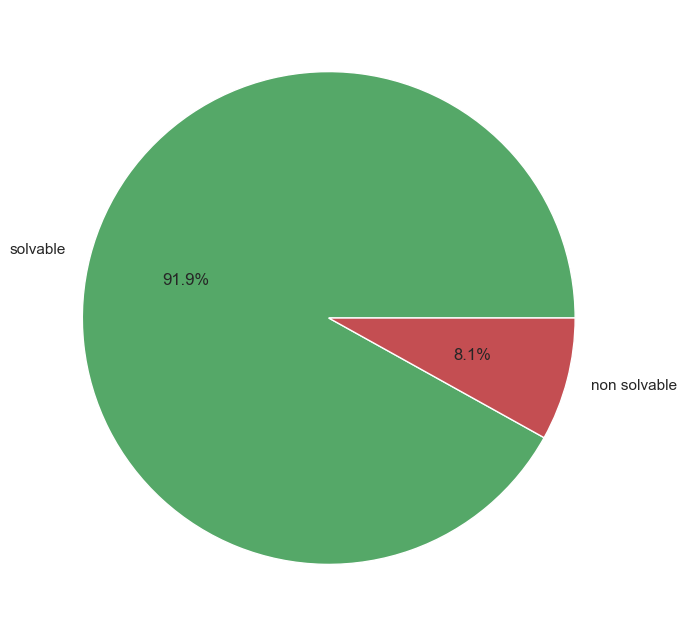

In [265]:
# Calcul du taux de 0, Imbalanced data rate
plt.figure(figsize = (8, 8))
plt.pie([nb_0,nb_1],labels=['solvable','non solvable'],autopct='%.1f%%',colors='gr')
plt.show()

# Sampled data

In [39]:
# Sampler le dataset pour obtenir des temps de traitement plus raisonnable
df_sample = df_final_without_ID.sample(frac=(1/16),
                            random_state=42)

In [40]:
# Vérifier si la proportion est respectée
df_sample.iloc[:,0].value_counts(normalize = True).round(2).unique()

array([0.92, 0.08])

In [41]:
X_sample = df_sample.drop('TARGET',axis=1)
y_sample = df_sample['TARGET']

In [42]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample,
                                                                                y_sample,
                                                                                train_size=0.8)

In [43]:
data_to_export = X_test_sample.join(y_test_sample)

In [44]:
data_to_export.head(5)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT,TARGET
18045,Cash loans,0,1,0,0,162000.0,472500.0,22860.0,472500.0,Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
102688,Cash loans,1,0,1,0,202500.0,1035000.0,29659.5,1035000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
158637,Cash loans,0,1,1,0,157500.0,675000.0,26284.5,675000.0,Unaccompanied,...,17319.645,1728.765,1732.32,1731.964500,17319.645,-2506.0,-2635.30,-26353.0,10.0,0.0
84287,Cash loans,1,0,0,0,90000.0,298512.0,16798.5,270000.0,Unaccompanied,...,504005.445,88.200,86707.08,14641.864875,585674.595,-256.0,-1373.15,-54926.0,40.0,0.0
270592,Cash loans,1,1,0,1,180000.0,256500.0,25497.0,256500.0,Family,...,54098.010,5.265,6750.00,3381.125625,27049.005,-2799.0,-2839.75,-22718.0,8.0,0.0


In [266]:
# Sauvegarde du test set
path_2 = '/Users/alexandredelaguillaumie/Documents/Projet 7/Exports'
filename = os.path.join(path_2,
                        'sample_test_set.pickle')
outfile = open(filename,
               'wb')
pickle.dump(data_to_export,
            outfile)
outfile.close()

# Pre-processing

In [51]:
numeric_features = numerical_list(X_sample)
numeric_transformer = Pipeline(
    steps=[("imputer",
            SimpleImputer(strategy="median")),
           ("scaler",
            StandardScaler())]
)

categorical_features = categorical_list(X_sample)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num",
         numeric_transformer,
         numeric_features),
        ("cat",
         categorical_transformer,
         categorical_features)])

# SMOTE data

In [52]:
preprocessor.fit(X_train_sample,y_train_sample)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CODE_GENDER', 'FLAG_OWN_CAR',
                                  'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                  'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLIS...
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2'

In [54]:
X_train_prepro = preprocessor.transform(X_train_sample)
X_train_prepro = pd.DataFrame(X_train_prepro,columns=column_names(X_train_sample))

In [55]:
X_train_prepro.dtypes.unique()

array([dtype('float64')], dtype=object)

In [57]:
X_test_prepro = preprocessor.transform(X_test_sample)
X_test_prepro = pd.DataFrame(X_test_prepro,columns=column_names(X_train_sample))

In [58]:
X_test_prepro.dtypes.unique()

array([dtype('float64')], dtype=object)

In [59]:
smote = SMOTE(random_state=42,
              sampling_strategy='minority')
X_train_sm, y_train_sm = smote.fit_resample(X_train_prepro, y_train_sample)

In [60]:
print('Prêt octroyé avant SMOTE: {}'.format(y_train_sample[y_train_sample == 0].shape[0]))
print('Prêt non octroyé avant SMOTE: {}'.format(y_train_sample[y_train_sample == 1].shape[0]))

Prêt octroyé avant SMOTE: 14098
Prêt non octroyé avant SMOTE: 1277


In [62]:
print('Prêt octroyé après SMOTE: {}'.format(y_train_sm[y_train_sm == 0].shape[0]))
print('Prêt non octroyé après SMOTE: {}'.format(y_train_sm[y_train_sm == 1].shape[0]))

Prêt octroyé après SMOTE: 14098
Prêt non octroyé après SMOTE: 14098


# Random Under Sampling (RUS) data

In [63]:
# Applique SMOTE aux imbalanced data
sm = RandomUnderSampler(random_state=42,
           sampling_strategy='majority')
X_train_rus,y_train_rus = sm.fit_resample(X_train_prepro,y_train_sample)

In [64]:
print('Prêt octroyé avant RUS: {}'.format(y_train_sample[y_train_sample == 0].shape[0]))
print('Prêt non octroyé avant RUS: {}'.format(y_train_sample[y_train_sample == 1].shape[0]))

Prêt octroyé avant RUS: 14098
Prêt non octroyé avant RUS: 1277


In [65]:
print('Prêt octroyé après RUS: {}'.format(y_train_rus[y_train_rus == 0].shape[0]))
print('Prêt non octroyé après RUS: {}'.format(y_train_rus[y_train_rus == 1].shape[0]))

Prêt octroyé après RUS: 1277
Prêt non octroyé après RUS: 1277


# Modeling

In [66]:
metier = metrics.make_scorer(eva_func,greater_is_better=True)

In [67]:
numeric_features = numerical_list(X_sample)
numeric_transformer = Pipeline(
    steps=[("imputer",
            SimpleImputer(strategy="median")),
           ("scaler",
            StandardScaler())]
)

categorical_features = categorical_list(X_sample)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num",
         numeric_transformer,
         numeric_features),
        ("cat",
         categorical_transformer,
         categorical_features)])

In [534]:
# permits to test different sampling strategies
def model_dummy(X_train_, X_test_, y_train_, y_test_):
    # set the path where it is stored
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    # set the name of the experiment folder
    mlflow.set_experiment('Dummy Models')
    # initialise counting time
    time1 = time.time()
    # executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        # give the run a name
        with mlflow.start_run(run_name='dummy/test') as run:
            # empty model
            cls = DummyClassifier()
            
            # fit to a certain data
            cls.fit(X_train_,
                    y_train_)
            # displays best params
            print("Best params : \n",
                  cls.get_params)
            # displays best score
            print("model score: %.3f" % cls.score(X_test_, y_test_))
            time2 = np.round(time.time() 
                             - time1,0)
            # gives timecode
            print("time : ",
                  time2)
            # predict a class with test data
            y_pred = cls.predict(X_test_)
            # return all metrics
            eval_metrics(y_test_,y_pred)
            # stores metrics into mlflow
            for name,score in zip(eval_metrics(y_test_,
                                               y_pred).keys(),
                                  eval_metrics(y_test_,
                                               y_pred).values()):
                mlflow.log_metric(name,
                                  score)
            # type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(cls,
                                         'dummy',
                                         registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(cls,
                                         'dummy')

In [532]:
# Imbalanced data
model_dummy(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params : 
 <bound method BaseEstimator.get_params of DummyClassifier()>
model score: 0.918
time :  0.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '24' of model 'CreditModels'.


In [533]:
# Oversampling (SMOTE)
model_dummy(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params : 
 <bound method BaseEstimator.get_params of DummyClassifier()>
model score: 0.918
time :  0.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '25' of model 'CreditModels'.


In [535]:
# Undersampling (RUS)
model_dummy(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params : 
 <bound method BaseEstimator.get_params of DummyClassifier()>
model score: 0.918
time :  0.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '26' of model 'CreditModels'.


In [563]:
# permits to test different sampling strategies
def model_dummy_rand(X_train_, X_test_, y_train_, y_test_):
    # set the path where it is stored
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    # set the name of the experiment folder
    mlflow.set_experiment('Dummy Models')
    # initialise counting time
    time1 = time.time()
    # executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        # give the run a name
        with mlflow.start_run(run_name='dummy/uniform') as run:
            # empty model
            cls = DummyClassifier(strategy='uniform')
            
            # fit to a certain data
            cls.fit(X_train_,
                    y_train_)
            # displays best params
            print("Best params : \n",
                  cls.get_params)
            # displays best score
            print("model score: %.3f" % cls.score(X_test_, y_test_))
            time2 = np.round(time.time() 
                             - time1,0)
            # gives timecode
            print("time : ",
                  time2)
            # predict a class with test data
            y_pred = cls.predict(X_test_)
            # return all metrics
            eval_metrics(y_test_,y_pred)
            # stores metrics into mlflow
            for name,score in zip(eval_metrics(y_test_,
                                               y_pred).keys(),
                                  eval_metrics(y_test_,
                                               y_pred).values()):
                mlflow.log_metric(name,
                                  score)
            # type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(cls,
                                         'dummy',
                                         registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(cls,
                                         'dummy')

In [564]:
# Imbalanced data
model_dummy_rand(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params : 
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
model score: 0.502
time :  0.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '40' of model 'CreditModels'.


In [565]:
# Oversampling (SMOTE)
model_dummy_rand(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params : 
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
model score: 0.502
time :  0.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '41' of model 'CreditModels'.


In [566]:
# Undersampling (RUS)
model_dummy_rand(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params : 
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
model score: 0.502
time :  0.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '42' of model 'CreditModels'.


In [542]:
# permits to test different sampling strategies
def model_lr(X_train_, X_test_, y_train_, y_test_):
    
    # params for LogisticRegression
    param_grid_lr = [
    {'solver': ['lbfgs'],
     'C': np.logspace(.5,7.5,8),
     'penalty': ['none']
    }]
    # set the path where it is stored
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    # set the name of the experiment folder
    mlflow.set_experiment('LogReg Models')
    # initialise counting time
    time1 = time.time()
    # executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        # give the run a name
        with mlflow.start_run(run_name='logistic_regression/sample') as run:
            # empty model
            cls = LogisticRegression()
            
            # hyperparams tuning
            grid_lr = GridSearchCV(estimator=cls,
                                   param_grid=param_grid_lr,
                                   return_train_score = True,
                                   error_score='raise',
                                   scoring=metier,
                                   cv =5)
            # fit to a certain data
            grid_lr.fit(X_train_,
                        y_train_)
            # displays best params
            print("Best params : \n",
                  grid_lr.best_params_)
            # displays best score
            print("model score: %.3f" % grid_lr.score(X_test_, 
                                                      y_test_))
            time2 = np.round(time.time() 
                             - time1,0)
            # gives timecode
            print("time : ",
                  time2)
            # predict a class with test data
            y_pred = grid_lr.predict(X_test_)
            # return all metrics
            eval_metrics(y_test_,y_pred)
            # stores metrics into mlflow
            for name,score in zip(eval_metrics(y_test_,
                                               y_pred).keys(),
                                  eval_metrics(y_test_,
                                               y_pred).values()):
                mlflow.log_metric(name,
                                  score)
            # stores params into mlflow
            for k,v in zip(grid_lr.best_params_.keys(),
                           grid_lr.best_params_.values()):
                mlflow.log_param(k,
                                 v)
            # type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid_lr,
                                         'lr',
                                         registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid_lr,
                                         'lr')

In [547]:
# Imbalanced data
model_lr(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params : 
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
model score: 0.567
time :  36.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '30' of model 'CreditModels'.


In [545]:
# Oversampling (SMOTE)
model_lr(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params : 
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
model score: 0.657
time :  74.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '28' of model 'CreditModels'.


In [546]:
# Undersampling (RUS)
model_lr(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params : 
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
model score: 0.659
time :  11.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '29' of model 'CreditModels'.


In [548]:
# permits to test different sampling strategies
def model_knn(X_train_, X_test_, y_train_, y_test_):
    name='knn'
    # params for NearestNeighbors
    param_grid = [
    {'n_neighbors': np.logspace(2,3,8).astype('int')
    }]
    # set the path where it is stored
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    # set the name of the experiment folder
    mlflow.set_experiment('KNeighbors Models')
    # initialise counting time
    time1 = time.time()
    # executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        # give the run a name
        with mlflow.start_run(run_name=name) as run:
            # empty model
            cls = KNeighborsClassifier()
            
            # hyperparams tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score = True,
                                error_score='raise',
                                scoring=metier,
                                cv =5)
            # fit to a certain data
            grid.fit(X_train_,
                     y_train_)
            # displays best params
            print("Best params : \n",
                  grid.best_params_)
            # displays best score
            print("model score: %.3f" % grid.score(X_test_,
                                                   y_test_))
            time2 = np.round(time.time() 
                             - time1,0)
            # gives timecode
            print("time : ",
                  time2)
            # predict a class with test data
            y_pred = grid.predict(X_test_)
            # return all metrics
            eval_metrics(y_test_,y_pred)
            # stores metrics into mlflow
            for k,v in zip(eval_metrics(y_test_,y_pred).keys(),
                                  eval_metrics(y_test_,y_pred).values()):
                mlflow.log_metric(k,v)
            # stores params into mlflow
            for k,v in zip(grid.best_params_.keys(),
                           grid.best_params_.values()):
                mlflow.log_param(k,v)
            # type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid,
                                         name,
                                         registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid,
                                         name)

In [549]:
# Imbalanced data
model_knn(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params : 
 {'n_neighbors': 100}
model score: 0.529
time :  389.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '31' of model 'CreditModels'.


In [550]:
# Oversampling (SMOTE)
model_knn(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params : 
 {'n_neighbors': 1000}
model score: 0.476
time :  1236.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '32' of model 'CreditModels'.


In [551]:
# Undersampling (RUS)
model_knn(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params : 
 {'n_neighbors': 719}
model score: 0.618
time :  31.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '33' of model 'CreditModels'.


In [552]:
# permits to test different sampling strategies
def model_rf(X_train_, X_test_, y_train_, y_test_):
    name='rf'
    # params for RandomForestClassifier
    param_grid = [
    {'n_estimators': [900,1000],
     'max_depth':  [7,9],
     'min_samples_split': [10,11]
    }]
    # set the path where it is stored
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    # set the name of the experiment folder
    mlflow.set_experiment('RandomF Models')
    # initialise counting time
    time1 = time.time()
    # executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        # give the run a name
        with mlflow.start_run(run_name=name) as run:
            # empty model
            cls = RandomForestClassifier()
            
            # hyperparams tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score = True,
                                error_score='raise',
                                scoring=metier,
                                cv =5)
            # fit to a certain data
            grid.fit(X_train_,
                     y_train_)
            # displays best params
            print("Best params : \n",
                  grid.best_params_)
            # displays best score
            print("model score: %.3f" % grid.score(X_test_,
                                                   y_test_))
            time2 = np.round(time.time() 
                             - time1,0)
            # gives timecode
            print("time : ",
                  time2)
            # predict a class with test data
            y_pred = grid.predict(X_test_)
            # return all metrics
            eval_metrics(y_test_,y_pred)
            # stores metrics into mlflow
            for k,v in zip(eval_metrics(y_test_,y_pred).keys(),
                                  eval_metrics(y_test_,y_pred).values()):
                mlflow.log_metric(k,v)
            # stores params into mlflow
            for k,v in zip(grid.best_params_.keys(),
                           grid.best_params_.values()):
                mlflow.log_param(k,v)
            # type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid,
                                         name,
                                         registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid,
                                         name)

In [553]:
# Imbalanced data
model_rf(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params : 
 {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 900}
model score: 0.529
time :  2457.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '34' of model 'CreditModels'.


In [554]:
# Oversampling (SMOTE)
model_rf(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params : 
 {'max_depth': 9, 'min_samples_split': 11, 'n_estimators': 900}
model score: 0.574
time :  3470.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '35' of model 'CreditModels'.


In [555]:
# Undersampling (RUS)
model_rf(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params : 
 {'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 900}
model score: 0.677
time :  262.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '36' of model 'CreditModels'.


In [556]:
# permits to test different sampling strategies
def model_xgb(X_train_, X_test_, y_train_, y_test_):
    name='xgb'
    # params for XGBClassifier
    param_grid = [
    {'n_estimators': [100,200],
     'max_depth': [3,4,5],
     'learning_rate': [0.05,.04]
    }]
    # set the path where it is stored
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    # set the name of the experiment folder
    mlflow.set_experiment('XGBoost Models')
    # initialise counting time
    time1 = time.time()
    # executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        # give the run a name
        with mlflow.start_run(run_name=name) as run:
            # empty model
            cls = XGBClassifier()
            
            # hyperparams tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score = True,
                                error_score='raise',
                                scoring=metier,
                                cv =5)
            # fit to a certain data
            grid.fit(X_train_,
                     y_train_)
            # displays best params
            print("Best params : \n",
                  grid.best_params_)
            # displays best score
            print("model score: %.3f" % grid.score(X_test_,
                                                   y_test_))
            time2 = np.round(time.time() 
                             - time1,0)
            # gives timecode
            print("time : ",
                  time2)
            # predict a class with test data
            y_pred = grid.predict(X_test_)
            # return all metrics
            eval_metrics(y_test_,y_pred)
            # stores metrics into mlflow
            for k,v in zip(eval_metrics(y_test_,y_pred).keys(),
                                  eval_metrics(y_test_,y_pred).values()):
                mlflow.log_metric(k,v)
            # stores params into mlflow
            for k,v in zip(grid.best_params_.keys(),
                           grid.best_params_.values()):
                mlflow.log_param(k,v)
            # type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid,
                                         name,
                                         registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid,
                                         name)

In [557]:
# Imbalanced data
model_xgb(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params : 
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
model score: 0.545
time :  1340.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '37' of model 'CreditModels'.


In [558]:
# Oversampling (SMOTE)
model_xgb(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params : 
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
model score: 0.534
time :  2947.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '38' of model 'CreditModels'.


In [559]:
# Undersampling (RUS)
model_xgb(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params : 
 {'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 200}
model score: 0.678
time :  381.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '39' of model 'CreditModels'.


# Split classique

In [68]:
X = df_final_without_ID.drop('TARGET',axis=1)
y = df_final_without_ID['TARGET']

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8)

In [72]:
# création d'un imputer pour préparer données streamlit
categorical_list_2 = []
numerical_list_2 = []
for i in X_train.columns.tolist():
    if X_train [i].dtype=='object':
        categorical_list_2.append(i)
    else:
        numerical_list_2.append(i)
simple_imputer = SimpleImputer(strategy='median').fit(X_train[numerical_list_2])
signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(simple_imputer,'imputer', signature=signature)

# Modèle final

In [206]:
y_test_

18045     1.0
102688    0.0
158637    0.0
84287     0.0
270592    0.0
         ... 
221825    0.0
207740    0.0
138520    0.0
263007    0.0
299762    0.0
Name: TARGET, Length: 3844, dtype: float64

In [208]:
X_train_, X_test_, y_train_, y_test_= X_train_rus, X_test_prepro, y_train_rus, y_test_sample
name='xgb_final'
# params for NearestNeighbors
param_grid = [
    # XGBClassifier
    {'n_estimators': [100,
                      300,
                      500],
     'max_depth': [3,
                   5,
                   7,
                   9],
     'learning_rate': (np.logspace(0.07,
                                   0.2,
                                   4,
                                   base=2)-1)
    }]
# set the path where it is stored
mlflow.set_tracking_uri("http://127.0.0.1:5000")
# set the name of the experiment folder
mlflow.set_experiment('XGBoost Models')
# initialise counting time
time1 = time.time()
# executed as a script
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(42)
    # give the run a name
    with mlflow.start_run(run_name=name) as run:
        # empty model
        cls = XGBClassifier()

        # hyperparams tuning
        grid = GridSearchCV(estimator=cls,
                            param_grid=param_grid,
                            return_train_score = True,
                            error_score='raise',
                            scoring=metier,
                            cv =5)
        # fit to a certain data
        grid.fit(X_train_,
                 y_train_)
        # displays best params
        print("Best params : \n",
              grid.best_params_)
        # predict a class with test data
        y_pred = grid.predict(X_test_)
        # return all metrics
        print('Scores avant application du threshold :')
        for k,v in zip(eval_metrics(y_test_,
                                    y_pred).keys(),
                       eval_metrics(y_test_,
                                    y_pred).values()):
            print('{} : {:.3f}'.format(k,v))
        print("model custom metric score: %.3f" % eva_func(y_test_,
                                                           y_pred))
        
        time2 = np.round(time.time() 
                         - time1,0)
        # gives timecode
        print("time : ",
              time2)
        # stores metrics into mlflow
        for k,v in zip(eval_metrics(y_test_,y_pred).keys(),
                       eval_metrics(y_test_,y_pred).values()):
            mlflow.log_metric(k,v)
        # stores params into mlflow
        for k,v in zip(grid.best_params_.keys(),
                       grid.best_params_.values()):
            mlflow.log_param(k,v)
        # type of storage
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(grid,
                                     name,
                                     registered_model_name="CreditModels")
        else:
            mlflow.sklearn.log_model(grid,
                                     name)

Best params : 
 {'learning_rate': 0.1486983549970351, 'max_depth': 7, 'n_estimators': 500}
Scores avant application du threshold :
balance_accuracy : 0.684
f1 : 0.261
roc_auc : 0.684
accuracy_score : 0.676
fbeta_score : 0.521
model custom metric score: 0.683
time :  7035.0


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '52' of model 'CreditModels'.


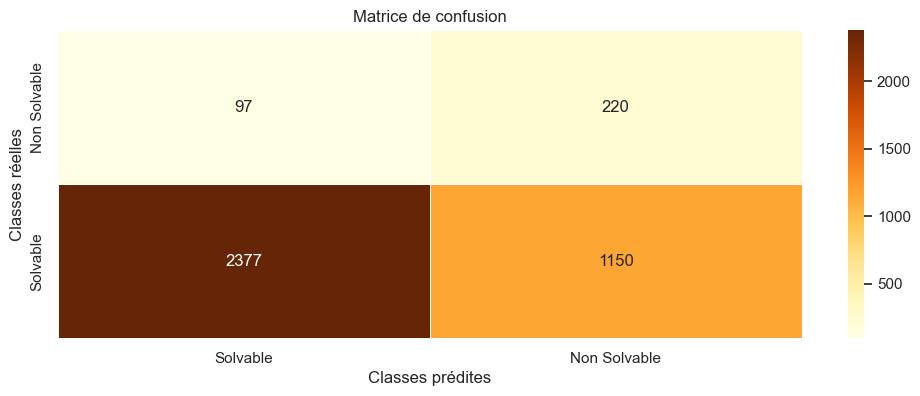

In [209]:
plot_heatmap_confusion(y_test_, y_pred)

# Préparation au déploiement

In [212]:
pipeline = Pipeline([('preprocessor', preprocessor), 
                     ('classifier', XGBClassifier(**grid.best_params_))])

In [229]:
pipeline.fit(X_train,
             y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELA

# Définition du seuil

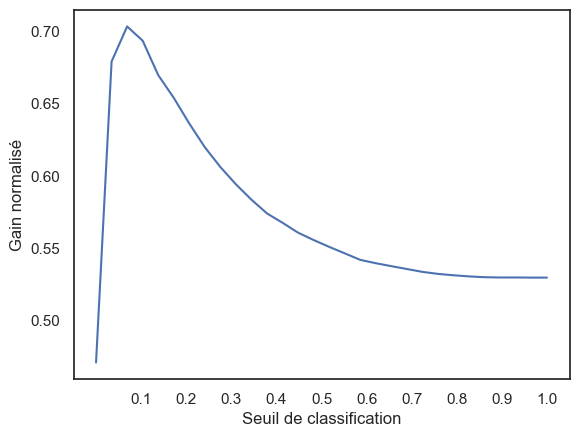

In [230]:
cost_function = []
threshold_x = np.linspace(0.0,
                          1,
                          30)
        
for threshold in threshold_x:

    # Score du modèle : 0 à 1
    y_scores = pipeline.predict_proba(X_test)[:, 1]

    # Score > seuil de solvabilité : retourne 1 sinon 0
    y_pred = (y_scores > threshold)
    y_pred = np.array(y_pred > 0) * 1
    
    # Calcul de l'indice bancaire
    cost_function.append(eva_func(y_test, y_pred))

# Affichage du gain en fonction du seuil de solvabilité    
plt.plot(threshold_x, cost_function)
plt.xlabel("Seuil de classification")
plt.ylabel("Gain normalisé")
plt.xticks(np.linspace(0.1,
                       1,
                       10))
plt.show()

In [231]:
threshold = []
for thresh, cost in zip(threshold_x, cost_function):
    if cost == max(cost_function):
        threshold.append(thresh)

# Modification de la prediction via un changement de threshold manuel
y_pred = pipeline.predict_proba(X_test)
y_pred = (y_pred[:,1] >= threshold )*1

In [232]:
#valeur du seuil
threshold[0]

0.06896551724137931

In [233]:
# nommer le model enregistré dans mlflow
name='xgb_threshold/'+str(threshold[0])

# set the path where it is stored
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# set the name of the experiment folder
mlflow.set_experiment('XGBoost Models')

# initialise counting time
time1 = time.time()

# executed as a script
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(42)
    # give the run a name
    with mlflow.start_run(run_name=name) as run:
        
        # return all metrics
        print('Scores après application du threshold :')
        for k,v in zip(eval_metrics(y_test,
                                    y_pred).keys(),
                       eval_metrics(y_test,
                                    y_pred).values()):
            print('{} : {:.3f}'.format(k,v))
        print("score custom metric : %.3f" % eva_func(y_test,
                                                     y_pred))
        time2 = np.round(time.time() 
                         - time1,0)
        
        # stores metrics into mlflow
        for k,v in zip(eval_metrics(y_test,
                                    y_pred).keys(),
                       eval_metrics(y_test,
                                    y_pred).values()):
            mlflow.log_metric(k,v)
            
        # stores params into mlflow
        for k,v in zip(grid.best_params_.keys(),
                       grid.best_params_.values()):
            mlflow.log_param(k,v)
            
        # type of storage
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(pipeline,
                                     name,
                                     registered_model_name="CreditModels")
        else:
            mlflow.sklearn.log_model(pipeline,
                                     name)

Scores après application du threshold :
balance_accuracy : 0.700
f1 : 0.292
roc_auc : 0.700
accuracy_score : 0.742
fbeta_score : 0.522
score custom metric : 0.703


Registered model 'CreditModels' already exists. Creating a new version of this model...
Created version '53' of model 'CreditModels'.


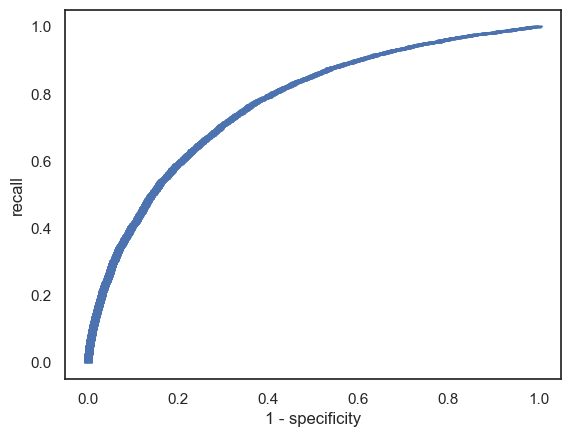

In [234]:
# Création des 3 valeurs de la matrice de confusion nécéssaire à l'affichage d'une AUC ROC
[fpr, tpr, thr]  = roc_curve(y_true=y_test,
                             y_score=pipeline.predict_proba(X_test)[:, 1])
# Courbe AUROC
plt.plot(fpr, tpr, marker="_")
plt.xlabel('1 - specificity')
plt.ylabel('recall')
plt.show()

In [235]:
# Enregistrement du modèle 
signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(pipeline, 'MLFlow Best Model', signature=signature)

# SHAP Values

In [128]:
## Quick import
# import joblib
# import os
# import pandas as pd
path = '/Users/alexandredelaguillaumie/Documents/Projet 7/MLFlow Best Model'
pipeline = joblib.load(os.path.join(path,'model.pkl'))
path2 = '/Users/alexandredelaguillaumie/Documents/Projet 7/Exports'
X_train = joblib.load(os.path.join(path2,'sample_test_set.pickle')).drop('TARGET',axis=1)

In [129]:
categorical_list_2 = []
numerical_list_2 = []
for i in X_train.columns.tolist():
    if X_train[i].dtype=='object':
        categorical_list_2.append(i)
    else:
        numerical_list_2.append(i)
        
# Récupérer le nom des catégories
cat = pipeline['preprocessor'].transformers_[1][1]\
      .get_feature_names_out(categorical_list_2)

# Enregistrer le model
classifier = pipeline.named_steps['classifier']

# Nom de l'ensemble des colonnes preprocessed
column_names = numerical_list_2+cat.tolist()

In [130]:
import shap
# Générer Shapley Values globales
df_preprocess = pd.DataFrame(pipeline.named_steps['preprocessor'].transform(X_train),
                             columns=column_names)
classifier = pipeline.named_steps['classifier']
explainer = shap.Explainer(classifier, df_preprocess)
shap_values = explainer(df_preprocess,check_additivity=False)

100%|===================| 10232/10251 [02:57<00:00]       

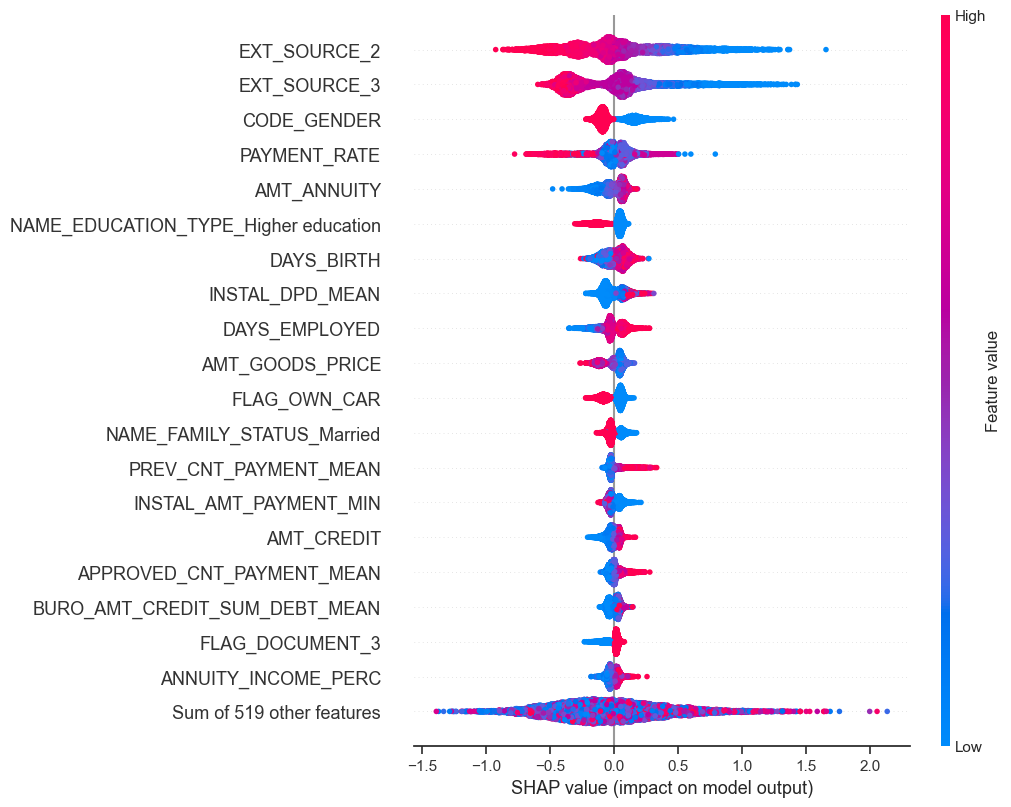

In [131]:
# Afficher interpretabilité globale
shap.plots.beeswarm(shap_values,max_display=20)

In [132]:
#Génerer shap values pour un client donné
client_id = X_train.index.tolist()[0]
list_ID = X_train.index.tolist()
index_ID = []
for ind, ID in enumerate(list_ID):
    if list_ID[ind] == client_id:
        index_ID.append(ind)
    else:
        pass
shap_values_client = shap_values[index_ID][0]

In [133]:
client_id

222044

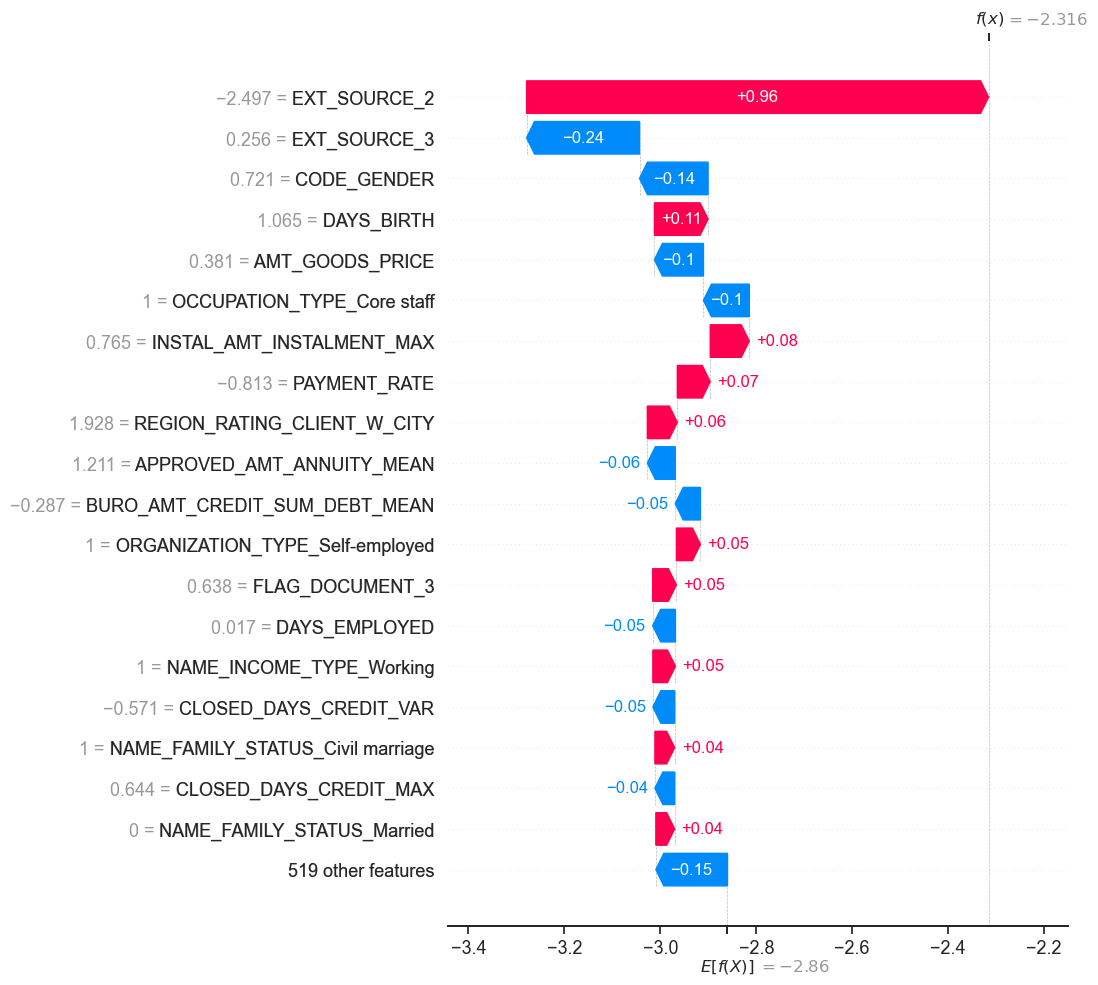

In [134]:
# Afficher interpretabilité locale
shap.plots.waterfall(shap_values_client,max_display=20)